## Synthetic Control for A/B Testing and RCTs

The synthetic control approach helps experimenters to estimate treatment effects without a control group.

**Example**

If you are a supermarket owner wants to estimate the effect of a 20% discount on ice cream sales, it is probably not a good idea to split ice cream products into two groups, implement the 20% discount on one group for the next week, and then look at the [difference in differences](https://en.wikipedia.org/wiki/Difference_in_differences).

$$\hat{e}_{discount}=\bar{\Delta}_{treatment} - \bar{\Delta}_{control}$$

This is because the treatment (20% discount) will likely reduce sales in of the control (group without discount) by making them less attractive to their alternatives. If $\bar{\Delta}_{control}$ is underestimated, $\hat{e}_{discount}$ is overestimated.

**Synthetic Control**

Synthetic control includes many methods that already commonly used, including comparing with previous month/year data. However, more generally, synthetic control method is about using predictive modeling to estimate what ice cream sales would be without the discount ( $\hat{\bar{y}}_{control, t=1}$). This is the outcome of our synthetic control group, which can be seen as an estimation of the real control group that doesn't exist.

$$\hat{e}_{discount}=\bar{\Delta}_{treatment} - \hat{\bar{\Delta}}_{control}=\bar{\Delta}_{treatment} - (\hat{\bar{y}}_{control, t=1} - \bar{y}_{control, t=0})$$

You can for instance use the sale of vegetables which has been historically predictive of ice cream sales, and can reasonably be independent of the discount. You might also use exogeneous variables such as weather or day of the week to better construct the synthetic control.

---

### Walmart example

In the code below, I will using Wal-mart sales data and hypothetical treatment and control groups to show how synthetic control can lead to a much better estimate than traditional A/B testing.

#### 0. Load packages and data

In [5]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
plt.style.use('seaborn')
%matplotlib inline

d = pd.read_csv('data\\walmart_sales_foods3_ca3.csv', index_col=0)
item_id = 8412
start, end = 250, 425
X = d.drop(item_id).T.iloc[start:end].reset_index(drop=True)
y = d.loc[item_id].iloc[start:end].reset_index(drop=True)
y = y/y.max() * 80
y.index.name = 'day'

#### 1. Create true effect of intervention

In [17]:
N = 50
effect_size = 12
treatment_effect = effect_size * (np.ones(N) + 0.2*np.random.randn(N))
treatment_effect[0] = 0

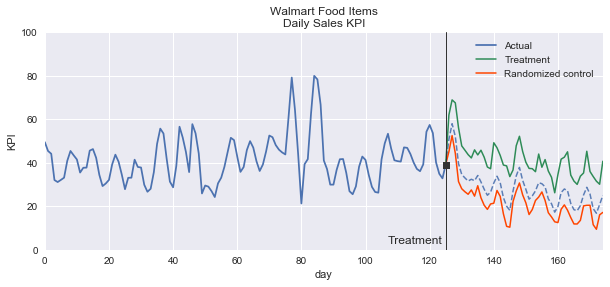

In [19]:
plt.figure(figsize=(10,4))
plt.ylim(0,100)

y[:-N+1].plot(label='Actual')
y.iloc[-N:].plot(c='C0', linewidth=1.5, linestyle='--', label='', alpha=0.9)

treatment = (y.iloc[-N:] + treatment_effect)
treatment.plot(c='seagreen', linewidth=1.5, label='Treatment')
control = (y.iloc[-N:] - .5*treatment_effect)
control.plot(c='orangered', linewidth=1.5, label='Randomized control')

plt.axvline(len(y)-N, c='#333333', linewidth=1, linestyle='-')
plt.plot(len(y)-N,y.iloc[-N], marker='s', color='#333333')
plt.annotate('Treatment', xy=(len(y)-N-1, 3), fontsize=12, ha='right')
plt.title('Walmart Food Items\nDaily Sales KPI')
plt.ylabel('KPI')
plt.legend();

**Fig:** the effect is assumed to have a negative impact on the sales of the control group and a positive impact on the treatment gruop. Only looking at the treatment group will not immediately tell us that there is a significant positive effect, because the actual sales went down after the time of the treatment.

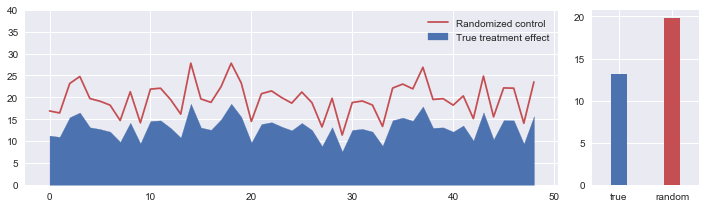

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,3), gridspec_kw={'width_ratios': [5, 1]})

obs_effect = (treatment - control).values[1:]
ax[0].fill_between(range(0,N-1), treatment_effect[1:], color='C0', label='True treatment effect')
ax[0].plot(obs_effect, c='C2', label='Randomized control')
ax[0].set_ylim(0,40)
ax[0].legend();

fig.tight_layout()
avg_effects = [treatment_effect[1:].mean(), obs_effect[1:].mean()]
ax[1].set_xlim(-.5, 1.5)
ax[1].bar(['true', 'random'], avg_effects, width=0.3, color=['C0', 'C2']);

**Fig:** as we can see, the true effect is consistently overestimated by about 50% if we used an traditional A/B testing framework.

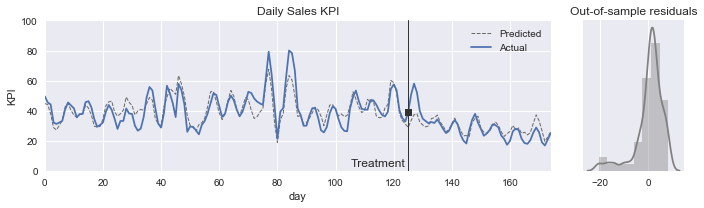

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,3), gridspec_kw={'width_ratios': [5, 1]})
ax[0].set_ylim(0,100)

corr = d.T.iloc[start:end].corr()[item_id].dropna()
top_items = corr.drop(item_id).abs().sort_values().index[-20:]
X_train = X.iloc[:-N][top_items]
y_train = y.iloc[:-N]
reg = Lasso(alpha=1).fit(X_train, y_train)
pred = pd.Series(reg.predict(X[X_train.columns]))
pred.index = y.index

ax[0].plot(pred, label='Predicted', c='dimgrey', linestyle='--', linewidth=1)
y.plot(label='Actual', ax=ax[0])

ax[0].legend()
ax[0].set_title('Daily Sales KPI')
ax[0].set_ylabel('KPI')
ax[1].set_title('Out-of-sample residuals')
ax[1].set_yticks([])

ax[0].axvline(len(y)-N, c='#333333', linewidth=1, linestyle='-')
ax[0].plot(len(y)-N,y.iloc[-N], marker='s', color='#333333')
ax[0].annotate('Treatment', xy=(len(y)-N-1, 3), fontsize=12, ha='right')
fig.tight_layout()
sns.distplot(pred.iloc[-N:] - y.iloc[-N:], bins=8, kde=True, ax=ax[1], color='grey');

**Fig:** using pre-treatment data, we can construct a model to estimate the sales KPI using the sales of other items at Wal-mart. Hypothetical post-treatment data should not be included in the training set since they cannot be observed, although using future exogenous data to retroactively predict sales KPI is fair game. Visually, the model has a decent in-sample fit so we shall proceed.

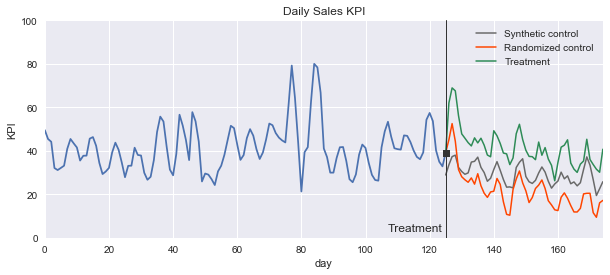

In [23]:
plt.figure(figsize=(10,4))
plt.ylim(0,100)

y[:-N+1].plot(label='')
pred[-N:].plot(c='dimgrey', linewidth=1.5, label='Synthetic control')

control = (y.iloc[-N:] - .5*treatment_effect)
control.plot(c='orangered', linewidth=1.5, label='Randomized control')

treatment = (y.iloc[-N:] + treatment_effect)
treatment.plot(c='seagreen', linewidth=1.5, label='Treatment')

plt.axvline(len(y)-N, c='#333333', linewidth=1, linestyle='-')
plt.plot(len(y)-N,y.iloc[-N], marker='s', color='#333333')
plt.annotate('Treatment', xy=(len(y)-N-1, 3), fontsize=12, ha='right')
plt.title('Daily Sales KPI')
plt.ylabel('KPI')
plt.legend();
#plt.axhline(0, linestyle='--', linewidth=1, color='black', alpha=0.7);

**Fig:** Here, the actual observations are replaced by the estimated sales KPI, our synthetic control.

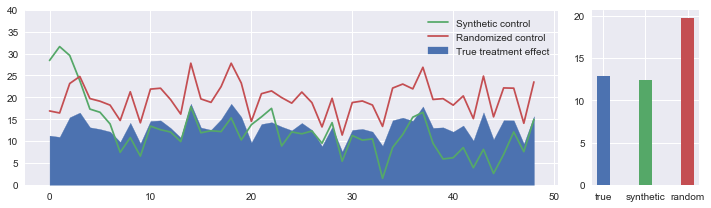

In [25]:
fig, ax = plt.subplots(1,2, figsize=(10,3), gridspec_kw={'width_ratios': [5, 1]})

synth_effect = (treatment - pred.iloc[-N:])[1:]
true_effect = treatment_effect[1:]
ax[0].fill_between(range(0,N-1), true_effect, color='C0', label='True treatment effect')
ax[0].plot(synth_effect.values, c='C1', label='Synthetic control')
ax[0].plot(obs_effect, c='C2', label='Randomized control')
ax[0].set_ylim(0,40)
ax[0].legend();

fig.tight_layout()
avg_effects = [treatment_effect.mean(), synth_effect.mean(), obs_effect.mean()]
ax[1].bar(['true', 'synthetic', 'random'], avg_effects, width=0.3, color=['C0', 'C1', 'C2']);

**Fig:** while the synthetic control seems to have high variance as expected, it seems to provide a much closer estimate of the treatment effect over ~50 time periods. The quality of the synthetic control relies on having an unbiased predictive model that has low variance. This is not always achievable but it seemed to have work out in this case.

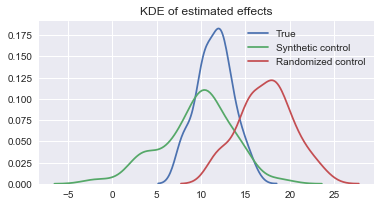

In [190]:
plt.figure(figsize=(6,3))
sns.distplot(true_effect, bins=5, hist=False, label='True')
synth_effect = treatment - pred.iloc[-N:]
sns.distplot(synth_effect, bins=5, hist=False, label='Synthetic control')
sns.distplot(obs_effect, bins=5, hist=False, label='Randomized control')
plt.title('KDE of estimated effects');